# Tutorial 1: Paleoclimate Proxies

**Week 1, Day 4, Paleoclimate**

**Content creators:** Sloane Garelick

**Content reviewers:** Brodie Pearson

**Content editors:** Yosmely Bermúdez, Agustina Pesce, Zahra Khodakaramimaghsoud

**Production editors:** TBD

**Our 2023 Sponsors:** TBD

###**Code and Data Sources**

Code for this tutorial is based on existing notebooks from LinkedEarth that [convert LiPD files to a Pandas dataframe](https://github.com/LinkedEarth/notebooks/blob/master/PAGES2k/01.lipd2df.ipynb) and [create a map of the PAGES2k network](https:///github.com/LinkedEarth/notebooks/blob/master/PAGES2k/02.plot_map.ipynb).

The following data is used in this tutorial:


*   PAGES2k Consortium. A global multiproxy database for temperature reconstructions of the Common Era. Sci Data 4, 170088 (2017). https://doi.org/10.1038/sdata.2017.88







# **Tutorial 1 Objectives**

In this tutorial, you'll learn about different types of paleoclimate proxies (physical characteristics of the environment that can stand in for direct measurements) and how they can be used to reconstruct past variations in Earth's climate on various spatial and temporal timescales. In the process of exploring examples of proxy types and datasets, you'll also learn some fundamental skills for working with [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/master/), a Python package designed for the analysis of paleoclimate data.


By the end of this tutorial you will be able to:

*   Understand some types of paleoclimate proxies and archives that exist
*   Create a global map of locations of proxy paleoclimate records in a specific data network 



# Setup

In [ ]:
# Install libraries
!pip install Pandas
!pip install pooch
!pip install matplotlib as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


In [ ]:
!pip install --no-binary shapely shapely --force # Add this to use cartopy. in this way it doesn't crush
!pip install cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.5/275.5 KB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 24.4 MB/s eta 0:00:00
  Created wheel for shapely: filename=shapely-2.0.1-cp39-cp39-linux_x86_64.whl size=979753 sha256=58fe7553932532f2e2a53ec3bc1b2f7dea006c29a1bee20736bc07d81fe5c91b
  Stored in directory: /root/.cache/pip/wheels/c2/f0/2b/e33fb469c9bf8d08688be4df902af6d7c2210128fc7c046889
Successfully built shapely
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.1
    Uninstalling shapely-2.0.1:
  

In [ ]:
!pip install LiPD

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.9/996.9 KB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.5/131.5 KB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 903.4/903.4 KB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 4.1 MB/s eta 0:00:00
  Created wheel for LiPD: filename=LiPD-0.2.8.9-py3-none-any.whl size=139967 sha256=41f3cdd36b47b729ec0b5123feb2ad8c50ea4b7dac76d2570efcd3ba59b5e8c1
  Stored in directory: /root/.cache/pip/wheels/8a/fa/c8/eb42fde467acb72e60a92c9c5e7bcda20c79c77c3cffff83b3
  Created wheel for demjson3: filename=demjson3-3.0.6-py3-none-any.whl size=75297 sha256=85c6ecab9ad849e0d48d4ff143bc9ff2c5dc916ea6ebe920441c638f00e04dce
  Stored in directory: /root/.cache/pip/wheels/bd/5d/ed/60c261589c275c950ad7f87a906849

In [ ]:
# Import libraries
import os
import pandas as pd
import numpy as np
import pooch # to donwload the  PAGES2K data
import matplotlib.pyplot as plt

import lipd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shapereader

## Common helper functions

In [ ]:
# @title Convert the PAGES2K LiDP files into a pandas.DataFrame

# Function to convert the PAGES2K LiDP files in a pandas.DataFrame
def lipd2df(lipd_dirpath, pkl_filepath=None, col_str=[
            'paleoData_pages2kID',
            'dataSetName', 'archiveType',                                                                                
            'geo_meanElev', 'geo_meanLat', 'geo_meanLon',
            'year', 'yearUnits',                                                                                         
            'paleoData_variableName',
            'paleoData_units',                                                                                           
            'paleoData_values',
            'paleoData_proxy']):
    """
    Convert a bunch of PAGES2k LiPD files to a `pandas.DataFrame` to boost data loading.

    If `pkl_filepath` isn't `None`, save the DataFrame as a pikle file.                
                                                   
    Parameters:
    ----------                                          
        lipd_dirpath: str
          Path of the PAGES2k LiPD files
        pkl_filepath: str or None
          Path of the converted pickle file. Default: `None`
        col_str: list of str
          Name of the variables to extract from the LiPD files
    
    Returns:
    -------                                                       
        df: `pandas.DataFrame`
          Converted Pandas DataFrame
    """
    
    # Save the current working directory for later use, as the LiPD utility will change it in the background
    work_dir = os.getcwd()
    # LiPD utility requries the absolute path
    lipd_dirpath = os.path.abspath(lipd_dirpath)
    # Load LiPD files
    lipds = lipd.readLipd(lipd_dirpath)
    # Extract timeseries from the list of LiDP objects
    ts_list = lipd.extractTs(lipds)
    # Recover the working directory
    os.chdir(work_dir)
    # Create an empty pandas.DataFrame with the number of rows to be the number of the timeseries (PAGES2k records),
    # and the columns to be the variables we'd like to extract 
    df_tmp = pd.DataFrame(index=range(len(ts_list)), columns=col_str)
    # Loop over the timeseries and pick those for global temperature analysis
    i = 0                                                                                                                
    for ts in ts_list:
        if 'paleoData_useInGlobalTemperatureAnalysis' in ts.keys() and \
            ts['paleoData_useInGlobalTemperatureAnalysis'] == 'TRUE':
            for name in col_str:                                                                                         
                try:
                    df_tmp.loc[i, name] = ts[name]                                                                       
                except:
                    df_tmp.loc[i, name] = np.nan                                                                         
            i += 1 
    # Drop the rows with all NaNs (those not for global temperature analysis)
    df = df_tmp.dropna(how='all')
    # Save the dataframe to a pickle file for later use
    if pkl_filepath:
        save_path = os.path.abspath(pkl_filepath)
        print(f'Saving pickle file at: {save_path}')
        df.to_pickle(save_path) 
    return df


## Convert PAGES2k LiPD files to a Pandas dataframe

As we've now seen from introductory video, there are various types of paleoclimate archives (e.g., sediment cores, corals, speleothems, tree rings, etc.) and proxies (e.g., isotopes, pollen, organic biomarkers, etc.). There are many existing paleoclimate reconstructions spanning a variety of timescales and from global locations. Given the temporal and spatial vastness of existing paleoclimate records, it can be challenging to know what paleoclimate data already exists and where to find it. A useful solution is compiling all existing paleoclimate records for a single climate variable (e.g., temperature, greenhouse gas concentration, precipitation, etc.) and over a specific time period (e.g., Holocene to present). 

One example of this is the **PAGES2k network**, which is a community-sourced database of temperature-sensitive proxy records. The database consists of 692 records from 648 locations, that are from a variety of archives (e.g., trees, ice, sediment, corals, speleothems, etc.) and span the Common Era (1 CE to present, i.e., the past ~2,000 years). You can read more about the PAGES2k network, in [PAGES 2k Consortium (2017)](https://www.nature.com/articles/sdata201788).

In this tutorial, we will explore the types of proxy records in the PAGES2k network and create a map of proxy record locations.

The PAGES2k network is stored in a specific file format known as Linked Paleo Data format (LiPD). LiPD files contain time series information in addition to supporting metadata (e.g., root metadata, location). Pyleoclim leverages this additional information using LiPD-specific functionality.

Data stored in the .lpd format can be loaded directly into Pyleoclim as a Lipd object. If the data_path points to one LiPD file, pyleo.Lipd will load the specific record, while if data_path points to a folder of lipd files, pyleo.Lipd will load the full set of records.

The first thing we need to do it to download the data and transform it into a DataFrame.

In [ ]:
# Set the name to save the PAGES2K data
fname = "pages2k_data"

# Download the data
lipd_file_paht = pooch.retrieve(
    url="https://ndownloader.figshare.com/files/8119937",
    known_hash=None,
    path="./",
    fname=fname,
    processor=pooch.Unzip()
)

In [ ]:
# Convert all the lipd file in a DataFrame
fname = "pages2k_data"

pages2k_data = lipd2df(lipd_dirpath="./"+f"{fname}"+".unzip/LiPD_Files", pkl_filepath=None)

Streaming output truncated to the last 5000 lines.
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Asia-CHOLPB.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Eur-Stockholm.Leijonhufvud.2010.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: O2kLR-CariacoBasin.Black.2007.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iterat

The PAGES2k data is now stored as a dataframe and we can view the data.

In [ ]:
# Print the PAGES2K data
pages2k_data.head()

,paleoData_pages2kID,dataSetName,archiveType,geo_meanElev,geo_meanLat,geo_meanLon,year,yearUnits,paleoData_variableName,paleoData_units,paleoData_values,paleoData_proxy
0,Ocn_116,Ocean2kHR-IndianAqabaHeiss1994AQ19,coral,-1.0,29.42,34.97,"[1992.0, 1991.0, 1990.0, 1989.0, 1988.0, 1987....",AD,d18O,permil,"[-2.87, -3.02, -2.8, -3.02, -3.02, -2.89, -3.0...",d18O
1,Asi_120,Asia-KMD,tree,3700.0,33.73,133.12,"[1600.0, 1601.0, 1602.0, 1603.0, 1604.0, 1605....",AD,trsgi,NA,"[0.934, 0.997, 0.79, 1.053, 0.683, 0.73, 1.072...",TRW
2,Asi_134,Asia-ULKEPS,tree,4300.0,43.35,77.35,"[1570.0, 1571.0, 1572.0, 1573.0, 1574.0, 1575....",AD,trsgi,NA,"[1.275, 1.193, 1.447, 1.662, 0.833, 1.128, 1.1...",TRW
3,Asi_121,Asia-BONKJT,tree,3720.0,40.17,72.58,"[1346.0, 1347.0, 1348.0, 1349.0, 1350.0, 1351....",AD,trsgi,NA,"[0.854, 0.762, 0.763, 0.828, 0.877, 0.975, 0.7...",TRW
4,Arc_002,Arc-Avam-Taimyr.Briffa.2008,tree,250.0,72.0,101.0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",AD,trsgi,NA,"[362.0, 399.0, 693.0, 727.0, 1148.0, 606.0, 75...",TRW


##Plotting a map of proxy reconstruction locations

Now that we have converted the data into a Pandas dataframe, we can create a map. We are going to plot the PAGES2k network on a map to understand the spatial distribution of the temperature records and the types of proxies that were measured.

Before genereting the plot, we have to define the colours and the marker types that we want to use in the plot. We also need to set a list with the different `archive_type` names that appear in the data frame.

In [ ]:
# Set a list of markers and colors for the different archive_type
markers = ['p', 'p', 'o', 'v', 'd', '*', 's', 's', '8', 'D', '^']
colors = [
    np.array([ 1., 0.83984375, 0.]),
    np.array([ 0.73828125, 0.71484375, 0.41796875]),
    np.array([ 1., 0.546875, 0.]),
    np.array([ 0.41015625, 0.41015625, 0.41015625]),
    np.array([ 0.52734375, 0.8046875 , 0.97916667]),
    np.array([ 0., 0.74609375, 1.]),
    np.array([ 0.25390625, 0.41015625, 0.87890625]),
    np.array([ 0.54296875, 0.26953125, 0.07421875]),
    np.array([ 1, 0, 0]),
    np.array([ 1., 0.078125  , 0.57421875]),
    np.array([ 0.1953125, 0.80078125, 0.1953125])
]

We are now going to create a plot that will allow us to see the PAGES2k network on a map.

/usr/local/lib/python3.9/dist-packages/cartopy/mpl/geoaxes.py:1700: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  result = super().scatter(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.9/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


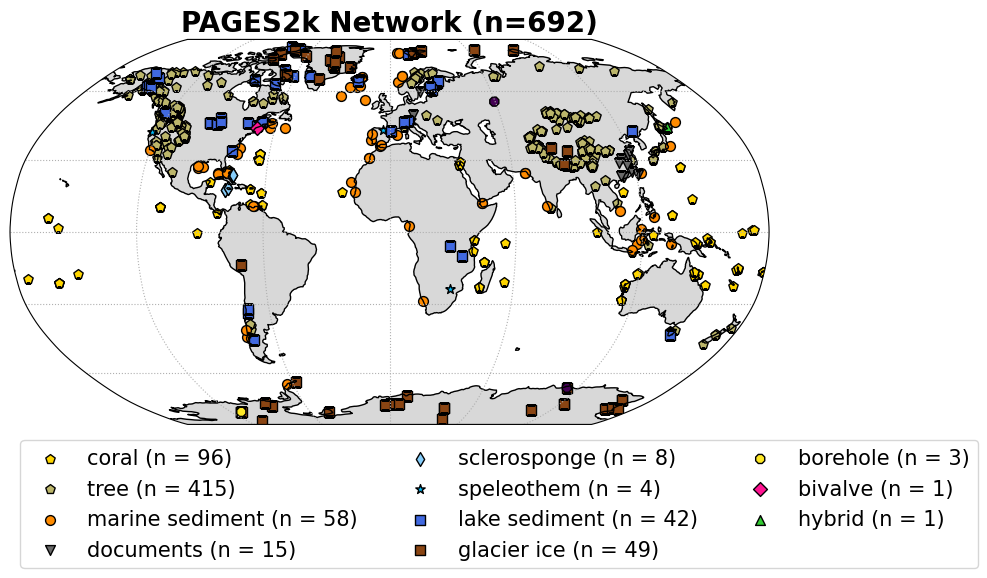

In [ ]:
# Create the plot

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

# Add plot title
plt.title(f'PAGES2k Network (n={len(pages2k_data)})', fontsize=20, fontweight='bold')

# Set the base map
# ----------------
ax.set_global()
# Add coast lines
ax.coastlines()
# Add land fratures using gray color
ax.add_feature(cfeature.LAND, facecolor='gray', alpha=0.3)
ax.gridlines(edgecolor='gray', linestyle=':')


# Plot the different archive types
# -------------------------------
# Extract the name of the different archive types
archive_types = pages2k_data.archiveType.unique()
# Plot the archive_type using a forloop
for i, type_i in enumerate(archive_types):
    df = pages2k_data[pages2k_data['archiveType']==type_i]
    # Count the number of appearances of the same archive_type
    count = df['archiveType'].count()
    # Generate the plot
    ax.scatter(
        df['geo_meanLon'], 
        df['geo_meanLat'], 
        marker=markers[i], 
        c=colors[i],
        edgecolor='k', 
        s=50, 
        transform=ccrs.Geodetic(), 
        label=f'{type_i} (n = {count})',
    )
# Add legend to the plot
ax.legend(
    scatterpoints=1,
    bbox_to_anchor=(0, -0.4),
    loc='lower left',
    ncol=3,
    fontsize=15,
)

plt.show()

Now you can see the global distribution and temperature proxy type of the 692 records in the PAGES2k network!

What do you notice about the map?

*   Which temperature proxy is the most and least abundant in this database?
*   In what region do you observe the most and least temperature records?


We can see the spatial distribution of paleoclimate temperature records spanning the past 2,000 years, but the next step is to extract and analyze the temperature time series of these reconstructions.
